# Controller Tuning
Finding constants

For info, see here: https://docs.google.com/document/d/1e9rO8AiSlSfKWVc_sojiy2BG749beE5V_XPPUCHijM0/edit?usp=sharing

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import control
import cmath
from pylab import *

In [2]:
# L = 0.015266817305695372     # Inductance
# C = -0.000004               # Lumped parameter - currently trying to find a way to properly tune this
# R = 2.41                     # Coil Resistance [ohms]

# # Linearization point - feel free to change thsese as well
# # Computing linearization point (find mass to use given a current and position setpoint)
# I_bar = 1.5 # TODO: compute ideal value of I_bar that perfectly offsets y_bar based on model
# y_bar = 0.03

# m = 3.0e-3 # Default mass - feel free to change
# # m = 6.0e-3
# #(-C * I_bar) / (9.81 * L * 2 * math.pi * y_bar**2) # Computes mass necessary for linearization point

In [3]:
MAX_VOLTAGE = 10.0                   # [V]
R = 2.41                             # Coil Resistance [ohms]
L = 0.015266817305695372             # Inductance [H]
c_I_to_V_h = 0.47996355000000007     # Computed scaling constant between electromagnet current and hall voltage
# Lumped parameter constants for V_h to position
hall_params = [2.58897620e-05, 2.49441669e+00, 1.35761509e-02]

# Lumped paramter in electromagnet current to position model
C1 = -0.0000025 # Hand-picked for now

# For computing hall voltage contribution from magnet
C2 = 0.86 # Electromagnet voltage scaling
C3 = 0.39 # Current derivative scaling

# Linearization setpoints
I_bar = 1.5 # Note: magnet will be pre-charged to this value
y_bar = 0.025 # Note: this is the point where we will try to control around


m = C1 * I_bar / (-9.81*L*4*math.pi*y_bar**2)
m

0.0031880407975657618

In [4]:
a2 = (C1 * I_bar) / (m * L * 2 * np.pi * y_bar**3)
np.sqrt(np.abs(a2)) # pole locations of second plant (+/-)

28.014282071829005

In [5]:
a1 = (-C1 * I_bar) / (m * 4 * np.pi * y_bar**2)

In [6]:
- R / L # pole locations of first plant

-157.85870438764837

$$ G_c = \frac{1}{R+Ls}$$
$$ G_e = \frac{a_1}{s^2+a_2} $$
$$ G = \frac{a_1}{Ls^3+Rs^2+La_2s+Ra_2}$$

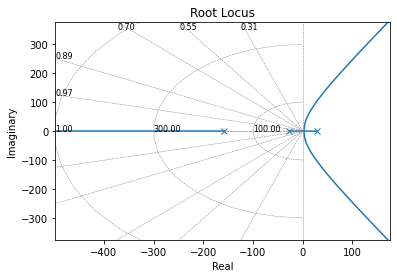

In [7]:
lti_uncontrolled = control.TransferFunction([a1], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti_uncontrolled)
plt.show()

$$ G = \frac{a_1}{Ls^3+Rs^2+La_2s+Ra_2}$$
$$ C_{PID} = K_P + \frac{K_I}{s} + K_Ds $$ 
$$ C_{PID} = \frac{K_Ds^2 + K_Ps + K_I}{s} $$

$$ GC = \frac{a_1 K_D s^2 + a_1 K_P s + a_1 K_I}{Ls^4+Rs^3+La_2s^2+Ra_2s}$$

#### Controller Considerations


Asymptotes at 
$$ q = \#\text{poles} - \#\text{zeros}$$ 
$$ q > 0 $$ 
$$\sigma = \frac{\sum{p_i} -\sum{z_i}}{q}$$


##### Contributing Factors for Asymptote

$$q = 4-2 = 2 $$

$$p_1 = \frac{-R}{L} = -157$$
$$p_2, p_3 = \sqrt{a_2} = \sqrt{\frac{CI_{bar}}{mL2\pi Y_{bar}^3}} = \pm 27 \text{  Don't contribute}$$
$$p_4 = 0$$

$$z_1, z_2 = \frac{-K_P \pm \sqrt{K_p^2 -4K_{I}K_{D}}}{2K_D} \text{ Imaginary portions cancel, important portion is KP/2KD} $$


Asymptote is at $$\frac{ \frac{-R}{L} - 2\frac{-K_P}{2K_D}}{q} = \frac{\frac{-R}{L} - \frac{-K_P}{K_D}}{2}$$

### pole-zero with two complex poles

-65.42935219382419


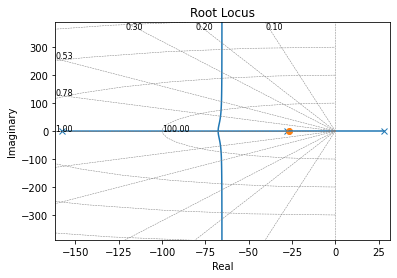

In [70]:
k = 855
kp = k*27
kd = k*1


asymptote = ((-R/L)-(-kp/kd))/2
print(asymptote)

# if 4*kd*ki < kp**2:
#     print("Check complexity of poles, -kp, +kd or +ki")

# if kp/(2*kd) < np.sqrt(np.abs(kp**2 - 4*kd*ki))/(2*kd):
#     print("Check proportionality, +kp, -kd")    

if asymptote > 0:
    print("Asymptote is in RHP, -kp or +kd")
    
lti = control.TransferFunction([a1*kd, a1*kp], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti)
rlist, klist = control.root_locus(lti,kvect=[1000],plot=False)

# plt.ylim([-100,100])
# plt.xlim([-200,50])
# plt.show()    
  
# extract real part
x = [ele.real for ele in rlist]
# extract imaginary part
y = [ele.imag for ele in rlist]



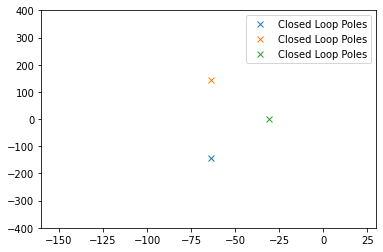

In [67]:
plt.plot(x,y, 'x', label="Closed Loop Poles")
plt.ylim([-400,400])
plt.xlim([-160,30])
plt.legend()
plt.show()

In [68]:
sys = signal.TransferFunction([a1*kd, a1*kp], [L, R, L*a2, R*a2])
sys.poles

array([-157.85870439,   28.01428207,  -28.01428207])

0.007126626335126586

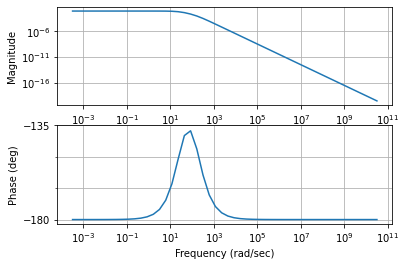

In [69]:
# k = 1500
# kp = k*180
# ki = k*16000
# kd = k*2.5

# lti = control.TransferFunction([a1*kd, a1*kp, a1*ki], [L, R, L*a2, R*a2,0])

f = np.logspace(-4,10)
w = 1*np.pi*f
mag, phase, w = control.bode(lti,w, dB = False)
gm, pm, sm, wg, wp, ws = control.stability_margins(lti)

mag[0]

In [ ]:
print("Gain Margin = ", gm)
loglog(w,mag)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Magnitude")
plt.title("Magnitude Bode Plot")

In [ ]:
print("omega_crossover =", wg )
semilogx(w,phase)
plt.axhline(y=-np.pi, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Phase(Degrees)")
plt.title("Phase Bode Plot")

Interesting pole-zero combos
180, 1600, 2.5 -> two complex zeros
180, 1600, 2.5 -> two complex zeros, dominating is non-ossilatory

error on the order of 0.01
Voltage electro magnet = 5

kp should be on the order of 500

### pole-zero plot with two real poles

In [ ]:
k = 1
kp = k*130
ki = k*1650
kd = k*2.5


asymptote = ((-R/L)-(-kp/kd))/2
left_z_neg_a2_pole_dist = -np.sqrt(np.abs(a2)) - ((-kp - np.sqrt(kp**2 -4*ki*kd))/(2*kd))
print("asymptote =", asymptote)
print("left zero, neg a2 pole dist = ", left_z_neg_a2_pole_dist)

if 4*kd*ki > kp**2:
    print("Check complexity of poles, -kp, +kd or +ki")

if kp/(2*kd) < np.sqrt(np.abs(kp**2 - 4*kd*ki))/(2*kd):
    print("Check proportionality, +kp, -kd")    

if asymptote > 0:
    print("Asymptote is in RHP, -kp or +kd")

if left_z_neg_a2_pole_dist < 0:
    print("Check left most zero, -kp or -kd")    
    
lti = control.TransferFunction([a1*kd, a1*kp, a1*ki], [L, R, L*a2, R*a2,0])
rlist, klist = control.root_locus(lti)
plt.show() 

In [ ]:
k = 300
kp = k*180
ki = k*1600
kd = k*2.5

lti = control.TransferFunction([a1*kd, a1*kp, a1*ki], [L, R, L*a2, R*a2,0])

f = np.logspace(-1,5)
w = 1*np.pi*f
mag, phase, w = control.bode(lti,w, dB = False)
gm, pm, sm, wg, wp, ws = control.stability_margins(lti)

In [ ]:
print("Gain Margin = ", gm)
loglog(w,mag)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Magnitude")
plt.title("Magnitude Bode Plot")

In [ ]:
print("omega_crossover =", wg )
semilogx(w,phase)
plt.axhline(y=-np.pi, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Phase(Degrees)")
plt.title("Phase Bode Plot")

System Notes/Numbers to try
- Sys 1
    - K = 1500
    - Kp = 180
    - Ki = 16000
    - Kd = 2.5
    - Open Loop
        - Two complex poles from controller
    - Closed Loop 
        - All osscilatory poles once stable    
        
- Sys 2
    - K = 300
    - Kp = 180
    - Ki = 1600
    - Kd = 2.5
    - Open Loop
        - Two real zeros from controller
    - Closed Loop 
        - Two dominating real poles, two ossilating poles        

### PD Controller

$$ G = \frac{a_1}{Ls^3+Rs^2+La_2s+Ra_2}$$

$$ C_{PD} = K_P + K_Ds $$ 

$$ GC_{OL} = \frac{a_1 K_D s + a_1 K_P}{Ls^3+Rs^2+La_2s+Ra_2}$$

$$ TF_{CL} = \frac{a_1 K_D s + a_1 K_P}{(Ls^3+Rs^2+La_2s+Ra_2) + (a_1 K_D s + a_1 K_P)}$$

#### Contributing Factors for Asymptote

$$q = 3 - 1 = 2 $$

$$p_1 = \frac{-R}{L} = -157$$
$$p_2, p_3 = \sqrt{a_2} = \sqrt{\frac{CI_{bar}}{mL2\pi Y_{bar}^3}} = \pm 27 \text{  Don't contribute}$$

$$z_1 = \frac{-K_P}{K_D}$$


Asymptote is at $$\frac{-R}{L} - \frac{-K_P}{K_D}$$

In [ ]:
asymptote = ((-R/L)-(-kp/kd))
 
    
lti = control.TransferFunction([a1*kd, a1*kp], [L, R, L*a2, R*a2])
rlist, klist = control.root_locus(lti)
plt.plot(TFcl_poles_real, TFcl_poles_imag, 'r*', label = "Closed Loop Poles")
plt.legend()
plt.show()

In [ ]:
f = np.logspace(-1,5)
w = 1*np.pi*f
mag, phase, w = control.bode(lti,w, dB = False)
gm, pm, sm, wg, wp, ws = control.stability_margins(lti)
print(wg, gm)

In [ ]:
print("Gain Margin = ", gm)
loglog(w,mag)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Magnitude")
plt.title("Magnitude Bode Plot")

In [ ]:
print("omega_crossover =", wg )
semilogx(w,phase)
plt.axhline(y=-np.pi, color='r', linestyle='-')
plt.axvline(x=wg, color='r', linestyle='-')
plt.xlabel("Omega")
plt.ylabel("Phase(Degrees)")
plt.title("Phase Bode Plot")